#  Trading Agricultural Commodity Stocks with MEI Models

## Our aim here is to choose our trade position based on MEI - Multivariate ENSO Index. We chose stocks which own agricultural farms or are directly impacted by supply quantity in a year. We try modelling MEI using AR / ARIMA / SARIMAX model. Stocks are detrended to focus on seasonality signal by ENSO. We expect to see negative correlation for MEI and stock's price. Hence, based upon model's prediction for future MEI, we choose to short the stock if MEI is >1.5σ (indicating el-nino) and long the stock when MEI recovers <1.25σ . This ensures we have a position that can be comparable to buy & hold while adjusting back positions when climate is suggestive of El-Nino.

## Data Sources

https://psl.noaa.gov/data/correlation/meiv2.csv

https://psl.noaa.gov/data/correlation/oni.csv

# Time Series Analysis for MEI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

In [2]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

In [3]:
import warnings
warnings.filterwarnings("ignore",message="Non-invertible starting MA parameters found")

In [4]:
mei = pd.read_csv('meiv2.csv')
mei['Date'] = pd.to_datetime(mei['Date'], format='%m/%d/%y')
mei = mei.rename(columns={'Multivariate ENSO Index': 'MEI'})
mei

,Date,MEI
0,1979-01-01,0.47
1,1979-02-01,0.29
2,1979-03-01,-0.05
3,1979-04-01,0.21
4,1979-05-01,0.27
...,...,...
550,2024-11-01,-0.68
551,2024-12-01,-0.91
552,2025-01-01,-1.00
553,2025-02-01,-0.83


In [5]:
mei.set_index('Date', inplace=True)
mei.index.freq = 'MS'

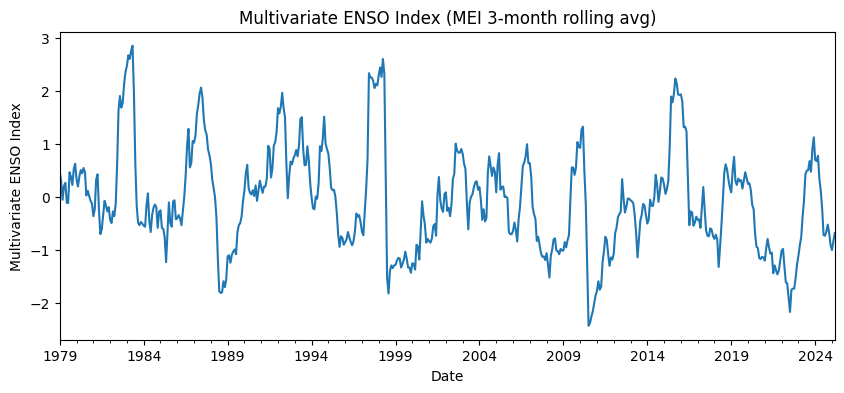

In [6]:
mei['MEI'].plot(title='Multivariate ENSO Index (MEI 3-month rolling avg)', figsize=(10,4))
plt.ylabel('Multivariate ENSO Index')
plt.show()

# Stocks Part Start

In [32]:
!pip install curl_cffi

In [75]:
raw = pd.read_csv('ADM_BG_CRESY_INGR_CTVA_NTR.csv', index_col=0, parse_dates=True)

In [33]:
from curl_cffi import requests
session = requests.Session(impersonate="chrome")
  # ticker = yf.Ticker('...', session=session)

In [76]:
tickers = {
    # South-American agri‐giant, planted/harvested first NYSE ADS in 2011
    #'Adecoagro SA':           {'ticker': 'AGRO',  'renewal_date': '2011-01-28'},

    # Founded 1902, first traded NYSE on Dec 24 1924
    'Archer-Daniels-Midland': {'ticker': 'ADM',   'renewal_date': '1924-12-24'},

    # World’s largest oilseed and grain trader, NYSE debut Aug 07 2001
    'Bunge Ltd':              {'ticker': 'BG',    'renewal_date': '2001-08-07'},

    # Argentine farm‐land conglomerate, ADR IPO Feb 22 2008
    'Cresud SA':              {'ticker': 'CRESY', 'renewal_date': '2008-02-22'},

    # US farmer-owned co-op, grain business; Preferred B 4 listed Jan 21 2025
    #CHS Inc (Pref B Series 4)': {'ticker': 'CHSCL','renewal_date': '2025-01-21'},
    #
    #'Anderson': {'ticker': 'ANDE','renewal_date': '2000-01-01'},
    'Ingredion': {'ticker': 'INGR', 'renewal_date': '2000-01-01'},
    'Corteva': {'ticker': 'CTVA', 'renewal_date': '2000-01-01'},
    'Nutrien': {'ticker': 'NTR', 'renewal_date': '2000-01-01'},
    #'Agricultural Mortgage': {'ticker': 'AGM', 'renewal_date': '2000-01-01'}
}


In [62]:
start, end = mei.index.min(), mei.index.max()
symbols = [v['ticker'] for v in tickers.values()]

In [63]:
symbols

['ADM', 'BG', 'CRESY', 'INGR', 'CTVA', 'NTR']

In [34]:
'''
import requests
session = requests.Session()
raw = yf.download(symbols, start=start, end=end, auto_adjust=False)['Close']
raw.to_csv('ADM_BG_CRESY_INGR_CTVA_NTR.csv')
'''

[*********************100%***********************]  6 of 6 completed


In [77]:
raw

,ADM,BG,CRESY,CTVA,INGR,NTR
Date,,,,,,
1980-03-17,1.848522,NaN,NaN,NaN,NaN,NaN
1980-03-18,1.907607,NaN,NaN,NaN,NaN,NaN
1980-03-19,1.932929,NaN,NaN,NaN,NaN,NaN
1980-03-20,1.983573,NaN,NaN,NaN,NaN,NaN
1980-03-21,1.932929,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-02-24,48.400002,73.580002,10.77,62.610001,130.300003,52.200001
2025-02-25,48.759998,74.269997,10.64,62.980000,132.479996,53.560001
2025-02-26,46.980000,73.260002,10.71,62.799999,130.570007,53.189999


In [78]:
symbols = [v['ticker'] for v in tickers.values()]

In [80]:
raw.columns

Index(['ADM', 'BG', 'CRESY', 'CTVA', 'INGR', 'NTR'], dtype='object')

In [81]:
prices = raw.resample('MS').last()

In [82]:
# 3. DETREND & OVERPLOT CYCLES vs. MEI
cycles = pd.DataFrame(index=prices.index)

for name, info in tickers.items():
    s = prices[info['ticker']].dropna()
    # HP‐filter into cycle & trend components (λ=129600 ≃ monthly data)
    cycle, trend = hpfilter(s, lamb=129600)
    cycles[name] = cycle

# Ensure MEI has datetime index
if not isinstance(mei.index, pd.DatetimeIndex):
    mei = mei.set_index('Date')

# Find the overlapping period between MEI and stock data
#start_date = max(mei.index.min(), cycles.index.min())
#end_date = min(mei.index.max(), cycles.index.max())

start_date = '2000-01-01'
end_date = '2025-01-01'

# Create a filtered dataframe
#df_filtered = [start_date:end_date]
#mei_filtered = df[start_date:end_date]

# Filter both datasets to the overlapping period
mei_filtered = mei.loc[start_date:end_date]
cycles_filtered = cycles.loc[start_date:end_date]

In [83]:
# Instead of dropping NAs, which removes rows with any missing values
df = pd.concat([mei_filtered['MEI'], cycles_filtered], axis=1)

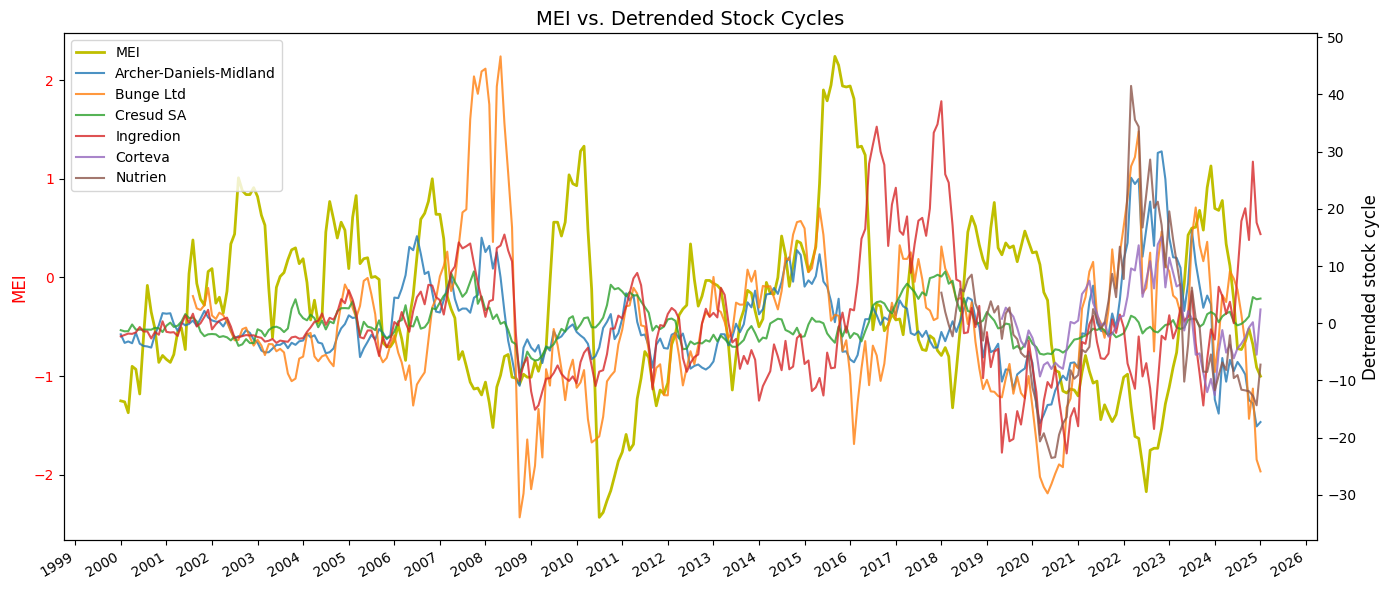

In [84]:
# Plot with handling of missing values
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Plot MEI on left y-axis (with gaps where data is missing)
ax1.plot(df.index, df['MEI'], color='y', linewidth=2, label='MEI')
ax1.set_ylabel('MEI', fontsize=12, color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot stock cycles on right y-axis (with gaps where data is missing)
for column in cycles_filtered.columns:
    ax2.plot(df.index, df[column], linewidth=1.5, alpha=0.8, label=column)

ax2.set_ylabel('Detrended stock cycle', fontsize=12)
ax1.set_title('MEI vs. Detrended Stock Cycles', fontsize=14)

# Improve x-axis formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

# Create legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

plt.tight_layout()
plt.show()


In [85]:
# Using method='pairwise' to only consider available pairs of observations
correlation = df.corr(method='pearson', min_periods=30)
print("Correlation of MEI with each stock cycle:\n", correlation.loc['MEI', cycles_filtered.columns])

Correlation of MEI with each stock cycle:
 Archer-Daniels-Midland   -0.158584
Bunge Ltd                -0.117904
Cresud SA                -0.147907
Ingredion                -0.072870
Corteva                  -0.595756
Nutrien                  -0.401355
Name: MEI, dtype: float64


In [86]:
ar_model = AutoReg(mei['MEI'], lags=6, old_names=False).fit()

In [87]:
best_sx = ((1, 0, 1), (1, 0, 1, 12))
sx_model = SARIMAX(mei['MEI'], order=best_sx[0], seasonal_order=best_sx[1],
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

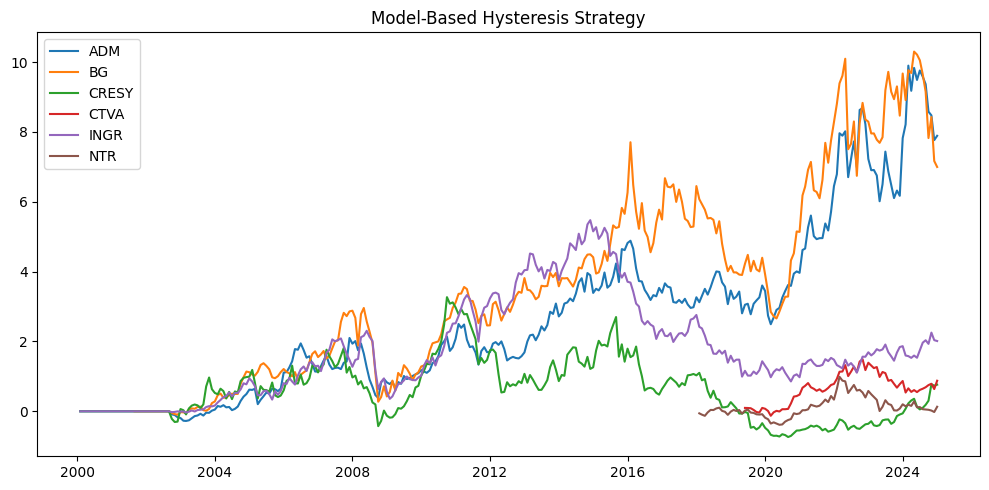

Final returns: ADM      788.8%
BG       699.5%
CRESY     76.2%
CTVA      87.5%
INGR     201.2%
NTR       12.9%
Name: 2025-01-01 00:00:00, dtype: object


In [88]:
#mei_fc = ar_model.predict(start=mei_filtered.index[0],end=mei_filtered.index[-1])
mei_fc = sx_model.predict(start=mei_filtered.index[0],end=mei_filtered.index[-1])

mei_fc = pd.Series(mei_fc, index=mei_filtered.index)

# 2) z‐score the forecast
mu, sigma = mei_filtered['MEI'].mean(), mei_filtered['MEI'].std()
z_fc = (mei_fc - mu) / sigma

# 3) hysteresis on the forecasted z‐score
signal = pd.Series(0, index=mei_filtered.index, dtype=int)
state = 0
for t in mei_filtered.index:
    if state != -1 and (z_fc.loc[t] >  1.5): #or z_fc.loc[t] <  -1.5):
    #if state != -1 and (z_fc.loc[t] >  1.5):
        state = -1       # forecast strongly positive → short
    elif state == -1 and z_fc.loc[t] < 1.25: #and z_fc.loc[prev_t] < 1.25:
        state = +1       # forecast has pulled back → long
    #prev_t = t - pd.tseries.frequencies.to_offset('MS')
    signal.loc[t] = state

# 4) apply to price returns and compute P&L
price_ret = prices.resample('MS').last().pct_change().loc[signal.index]
strat_ret = price_ret.mul(signal.shift(1), axis=0)

cum_ret = (1 + strat_ret).cumprod().subtract(1)
plt.figure(figsize=(10,5))
for col in cum_ret:
    plt.plot(cum_ret.index, cum_ret[col], label=col)
plt.title("Model-Based Hysteresis Strategy")
plt.legend(); plt.tight_layout(); plt.show()

print("Final returns:", (cum_ret.iloc[-1]*100).round(1).astype(str) + "%")


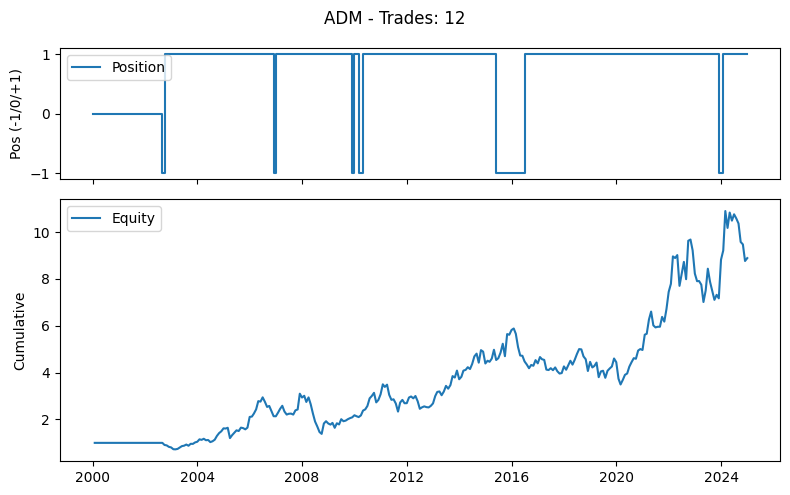


=== ADM Trades ===
symbol      entry       exit  signal  trade_return  holding_months
   ADM 2002-09-01 2002-09-01      -1      0.000000               1
   ADM 2002-10-01 2006-11-01       1      1.348430              50
   ADM 2006-12-01 2006-12-01      -1     -0.089459               1
   ADM 2007-01-01 2009-11-01       1     -0.038393              35
   ADM 2009-12-01 2009-12-01      -1      0.016228               1
   ADM 2010-01-01 2010-02-01       1      0.021573               2
   ADM 2010-03-01 2010-04-01      -1      0.017030               2
   ADM 2010-05-01 2015-05-01       1      1.291272              61
   ADM 2015-06-01 2016-06-01      -1     -0.051853              13
   ADM 2016-07-01 2023-11-01       1      0.552025              89
   ADM 2023-12-01 2024-01-01      -1      0.205208               2
   ADM 2024-02-01 2025-01-01       1      0.007469              12


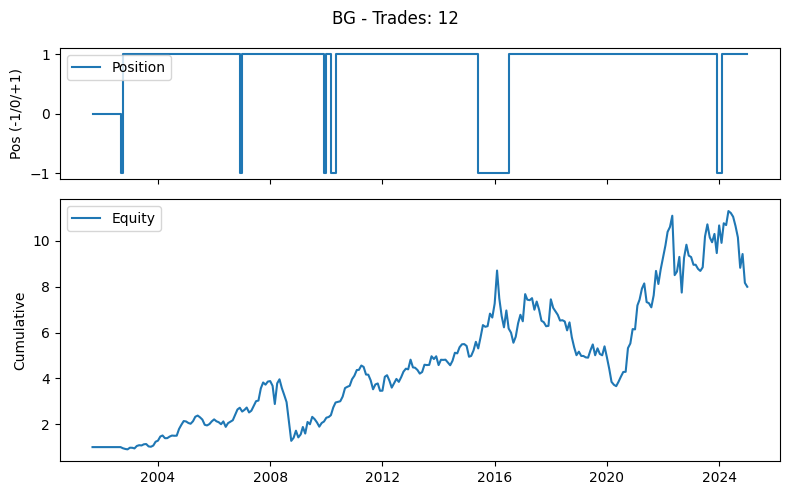


=== BG Trades ===
symbol      entry       exit  signal  trade_return  holding_months
    BG 2002-09-01 2002-09-01      -1      0.000000               1
    BG 2002-10-01 2006-11-01       1      1.642333              50
    BG 2006-12-01 2006-12-01      -1      0.028511               1
    BG 2007-01-01 2009-11-01       1     -0.244838              35
    BG 2009-12-01 2009-12-01      -1      0.031179               1
    BG 2010-01-01 2010-02-01       1      0.093642               2
    BG 2010-03-01 2010-04-01      -1      0.179896               2
    BG 2010-05-01 2015-05-01       1      1.048490              61
    BG 2015-06-01 2016-06-01      -1      0.244362              13
    BG 2016-07-01 2023-11-01       1      0.480004              89
    BG 2023-12-01 2024-01-01      -1      0.035861               2
    BG 2024-02-01 2025-01-01       1     -0.250793              12


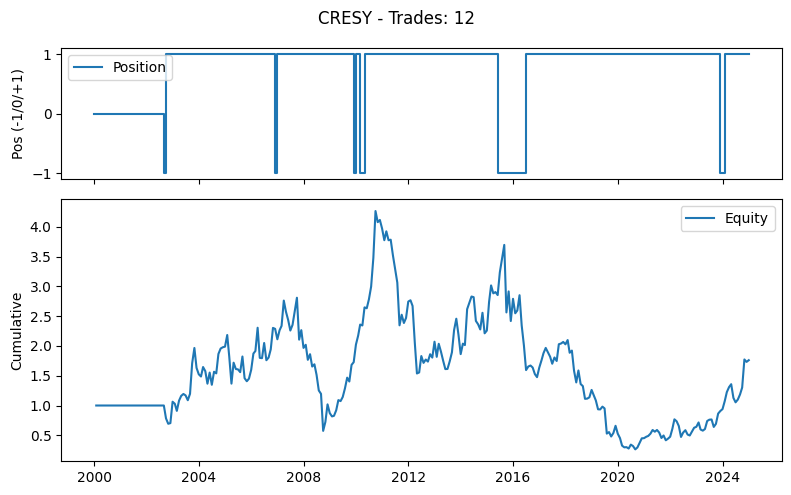


=== CRESY Trades ===
symbol      entry       exit  signal  trade_return  holding_months
 CRESY 2002-09-01 2002-09-01      -1      0.000000               1
 CRESY 2002-10-01 2006-11-01       1      1.304037              50
 CRESY 2006-12-01 2006-12-01      -1     -0.006916               1
 CRESY 2007-01-01 2009-11-01       1     -0.264594              35
 CRESY 2009-12-01 2009-12-01      -1      0.027085               1
 CRESY 2010-01-01 2010-02-01       1      0.257906               2
 CRESY 2010-03-01 2010-04-01      -1      0.078660               2
 CRESY 2010-05-01 2015-05-01       1      0.239433              61
 CRESY 2015-06-01 2016-06-01      -1     -0.308746              13
 CRESY 2016-07-01 2023-11-01       1     -0.569949              89
 CRESY 2023-12-01 2024-01-01      -1      0.087486               2
 CRESY 2024-02-01 2025-01-01       1      0.874880              12


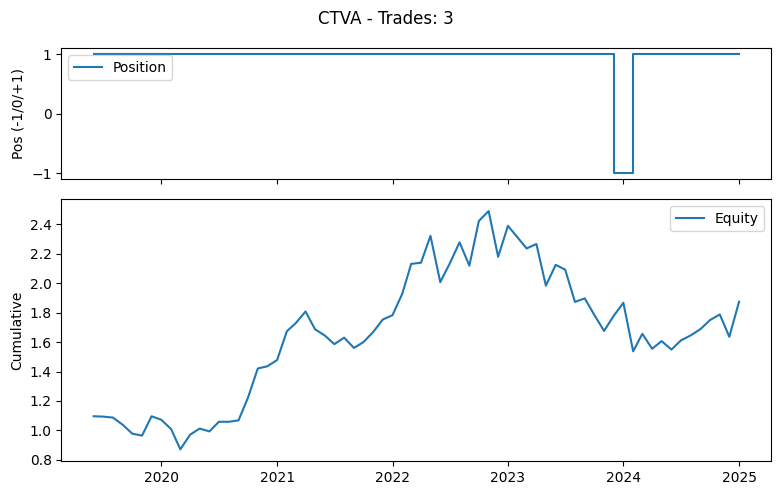


=== CTVA Trades ===
symbol      entry       exit  signal  trade_return  holding_months
  CTVA 2019-06-01 2023-11-01       1      0.675936              54
  CTVA 2023-12-01 2024-01-01      -1      0.114159               2
  CTVA 2024-02-01 2025-01-01       1      0.003952              12


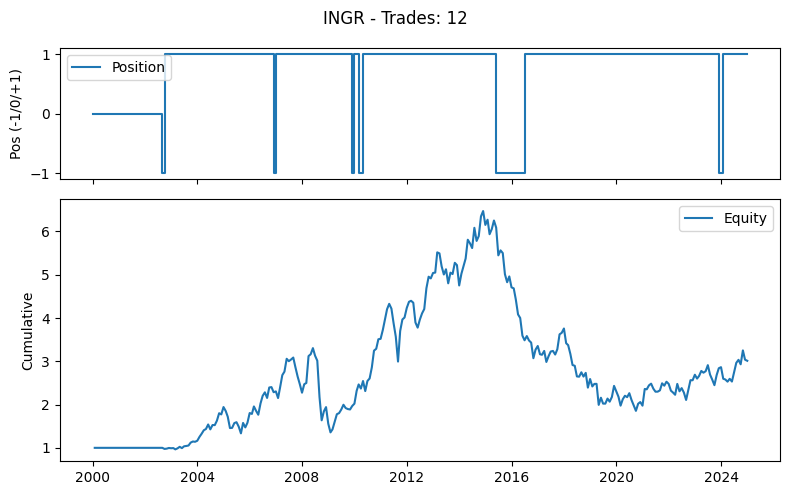


=== INGR Trades ===
symbol      entry       exit  signal  trade_return  holding_months
  INGR 2002-09-01 2002-09-01      -1      0.000000               1
  INGR 2002-10-01 2006-11-01       1      1.403150              50
  INGR 2006-12-01 2006-12-01      -1     -0.049009               1
  INGR 2007-01-01 2009-11-01       1     -0.174440              35
  INGR 2009-12-01 2009-12-01      -1      0.042439               1
  INGR 2010-01-01 2010-02-01       1      0.178143               2
  INGR 2010-03-01 2010-04-01      -1      0.022713               2
  INGR 2010-05-01 2015-05-01       1      1.638798              61
  INGR 2015-06-01 2016-06-01      -1     -0.425576              13
  INGR 2016-07-01 2023-11-01       1     -0.253552              89
  INGR 2023-12-01 2024-01-01      -1      0.068299               2
  INGR 2024-02-01 2025-01-01       1      0.051433              12


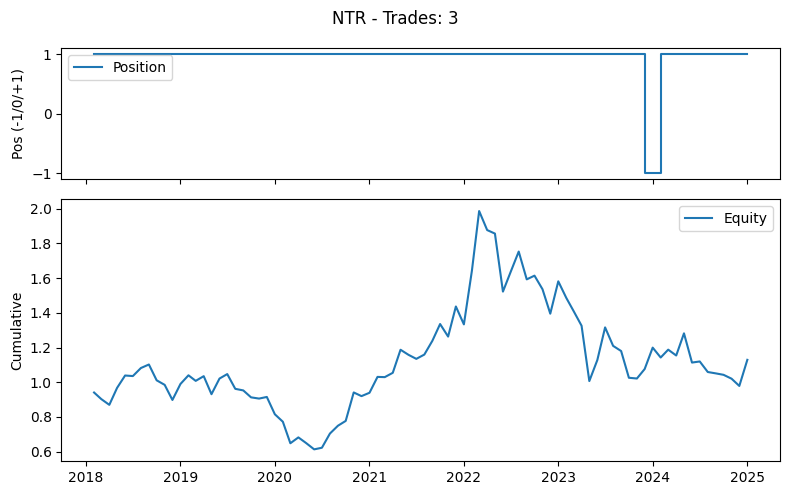


=== NTR Trades ===
symbol      entry       exit  signal  trade_return  holding_months
   NTR 2018-02-01 2023-11-01       1      0.021590              70
   NTR 2023-12-01 2024-01-01      -1      0.174303               2
   NTR 2024-02-01 2025-01-01       1     -0.058646              12

=== Strategy Summary ===
        STR Sharpe  STR MaxDD%  STR Turnover  STR AvgHold  BH Sharpe  \
symbol                                                                 
ADM       0.469839  -55.352144      0.038206    22.416667   0.357932   
BG        0.453830  -67.822737      0.040925    22.416667   0.356321   
CRESY     0.279179  -93.835638      0.038206    22.416667   0.266545   
CTVA      0.557591  -38.270842      0.029412    22.666667   0.735612   
INGR      0.306797  -71.345689      0.038206    22.416667   0.459302   
NTR       0.207747  -50.734486      0.023810    28.000000   0.145489   

        BH MaxDD%  BH Turnover  BH AvgHold  NumTrades  
symbol                                               

In [89]:
results = []

for sym in strat_ret.columns:
    #a) assemble per-symbol DataFrame
    df_i = pd.DataFrame({
        'signal':   signal,
        'strat_ret':strat_ret[sym],
        'price_ret':price_ret[sym]
    }).dropna(subset=['price_ret'])
    df_i['pos_change'] = df_i['signal'].diff().fillna(0)
    df_i['trade_id']   = (df_i['pos_change'] != 0).cumsum()

    #b) trade-by-trade stats
    trades = []
    for tid in df_i.loc[df_i.signal != 0, 'trade_id'].unique():
        tr = df_i[df_i.trade_id == tid]
        trades.append({
            'symbol':         sym,
            'entry':          tr.index[0],
            'exit':           tr.index[-1],
            'signal':       tr.signal.iloc[0],
            'trade_return':   (1 + tr['strat_ret']).prod() - 1,
            'holding_months': len(tr)
        })
    trades_df = pd.DataFrame(trades)

    #c) strategy metrics
    strat_sr     = df_i['strat_ret'].mean() / df_i['strat_ret'].std() * np.sqrt(12)
    strat_equity = (1 + df_i['strat_ret']).cumprod()
    strat_dd     = (strat_equity / strat_equity.cummax() - 1).min()
    strat_turn   = df_i['pos_change'].abs().sum()/2 / len(df_i)
    strat_hp     = trades_df['holding_months'].mean() if not trades_df.empty else np.nan

    #d) buy-&-hold metrics on the same price_ret
    bh_sr     = df_i['price_ret'].mean() / df_i['price_ret'].std() * np.sqrt(12)
    bh_equity = (1 + df_i['price_ret']).cumprod()
    bh_dd     = (bh_equity / bh_equity.cummax() - 1).min()
    # turnover = 0, holding = whole sample
    bh_turn   = 0.0
    bh_hp     = len(df_i)

    #e) collect results
    results.append({
        'symbol':       sym,
        # strategy
        'STR Sharpe':   strat_sr,
        'STR MaxDD%':   strat_dd*100,
        'STR Turnover': strat_turn,
        'STR AvgHold':  strat_hp,
        # buy-&-hold
        'BH Sharpe':    bh_sr,
        'BH MaxDD%':    bh_dd*100,
        'BH Turnover':  bh_turn,
        'BH AvgHold':   bh_hp,
        'NumTrades':    len(trades_df)
    })

    # d) plot for this symbol
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,5), sharex=True,
                                   gridspec_kw={'height_ratios':[1,2]})
    ax1.step(df_i.index, df_i.signal, where='post', label='Position')
    ax1.set_ylabel('Pos (-1/0/+1)')
    ax1.legend(loc='upper left')

    ax2.plot(strat_equity, label='Equity')
    ax2.set_ylabel('Cumulative')
    ax2.legend()
    fig.suptitle(f"{sym} - Trades: {len(trades_df)}")
    plt.tight_layout()
    plt.show()

    # e) print that symbol's trades
    print(f"\n=== {sym} Trades ===")
    print(trades_df.to_string(index=False))

# f) summary table
metrics_df = pd.DataFrame(results).set_index('symbol')
print("\n=== Strategy Summary ===")
print(metrics_df)
